In [1]:
library(Kendall)
library(tidyverse)
library(infotheo)
library(graphics)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




In [2]:
GIT_ROOT <- system2('git', args=c('rev-parse', '--show-toplevel'), stdout=TRUE)
DATA <- file.path(GIT_ROOT, 'data')
DATASET_PATH <- file.path(DATA, 'combined_data.csv')

In [3]:
summarize_dataset <- function(dataset) {
    total_samples <- nrow(dataset)
    sprintf('total samples: %d\n', total_samples) %>% cat()
    for (column in names(dataset)) {
        not_null <- sum(complete.cases(dataset[[column]]))
        percent_not_null = not_null / total_samples * 100
        sprintf('%s (not null): %d (%.1f%%)\n', column, not_null, percent_not_null) %>% cat()
    }
    
}

In [4]:
compare_category_variance <- function(data, attribute) {
    for(num in 0:4) {
        population <- data[data$num == num,][[attribute]]
        variance <- var(population)
        normality <- shapiro.test(population)
        sprintf('Category %d variance: %.1f Shapiro-Wilk p-value: %.4f\n', 
                num, 
                variance,
                normality[['p.value']]) %>% cat()
    }
}

In [5]:
fligner_killeen <- function(data, attribute) {
    x <- list(zero=data[data$num == 0,][[attribute]],
              one=data[data$num == 1,][[attribute]],
              two=data[data$num == 2,][[attribute]],
              three=data[data$num == 3,][[attribute]],
              four=data[data$num == 4,][[attribute]])
    
    return(fligner.test(x))
}

In [17]:
outliers <- function(x) {
    lower_bound <- quantile(x, 0.025)
    upper_bound <- quantile(x, 0.975)
    outlier_indices <- which(x < lower_bound | x > upper_bound)
    return(sort(x[outlier_indices]))
}

In [7]:
heart_disease_data <- read_csv(DATASET_PATH)
sprintf('dataset: %s\n', DATASET_PATH) %>% cat()
summarize_dataset(heart_disease_data)

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  thalrest = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  smoke = col_double(),
  cigs = col_double(),
  years = col_double(),
  famhist = col_double(),
  num = col_double()
)



dataset: /home/jgenson/Development/cardiac/data/combined_data.csv
total samples: 617
age (not null): 617 (100.0%)
sex (not null): 617 (100.0%)
cp (not null): 617 (100.0%)
thalrest (not null): 561 (90.9%)
trestbps (not null): 558 (90.4%)
chol (not null): 587 (95.1%)
fbs (not null): 527 (85.4%)
restecg (not null): 615 (99.7%)
thalach (not null): 562 (91.1%)
exang (not null): 562 (91.1%)
oldpeak (not null): 555 (90.0%)
slope (not null): 309 (50.1%)
smoke (not null): 230 (37.3%)
cigs (not null): 202 (32.7%)
years (not null): 190 (30.8%)
famhist (not null): 195 (31.6%)
num (not null): 617 (100.0%)


In [8]:
# Sample size of each category in num (the target attribute)
zeroes = sum(heart_disease_data$num == 0)
ones = sum(heart_disease_data$num == 1)
twos = sum(heart_disease_data$num == 2)
threes = sum(heart_disease_data$num == 3)
fours = sum(heart_disease_data$num == 4)
sprintf('0: %d\n', zeroes) %>% cat()
sprintf('1: %d\n', ones) %>% cat()
sprintf('2: %d\n', twos) %>% cat()
sprintf('3: %d\n', threes) %>% cat()
sprintf('4: %d\n', fours) %>% cat()

0: 247
1: 141
2: 99
3: 100
4: 30


In [9]:
# Summary statistics for attribute age.
summary(heart_disease_data$age, na.rm=T)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  28.00   47.00   54.00   53.06   60.00   77.00 

In [10]:
# Potential outliers in attribute age.
outliers <- outliers(heart_disease_data$age)
print(outliers)

 [1] 28 29 29 30 31 31 32 32 32 32 32 33 33 72 72 72 72 73 74 74 74 74 74 74 75
[26] 75 75 76 77


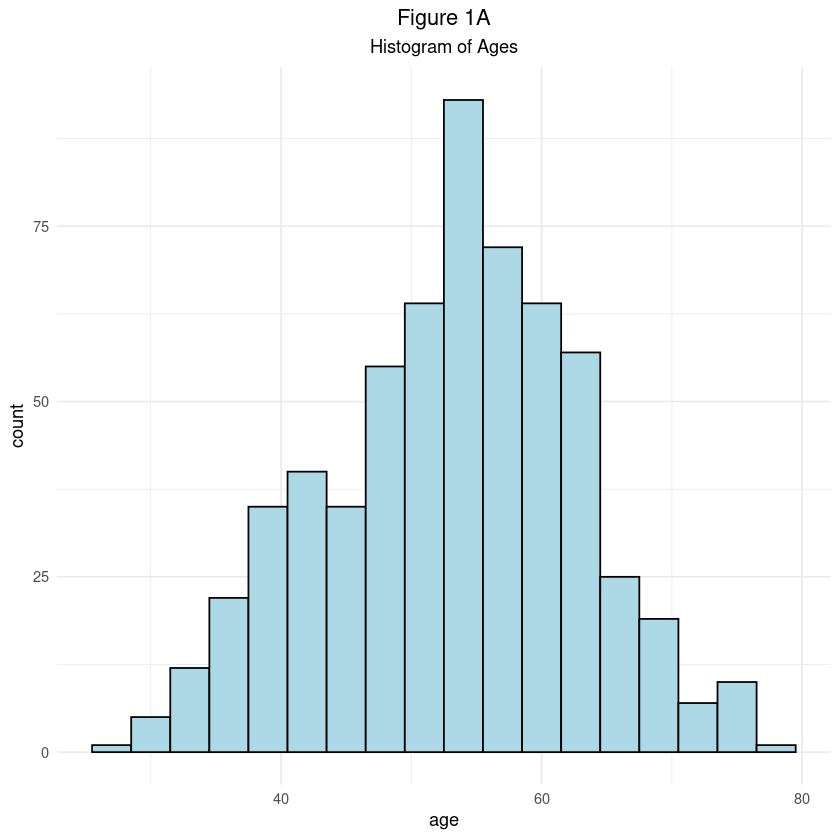

In [11]:
# Histogram of attribute age.
ggplot(heart_disease_data, aes(x=age)) + ggtitle(label='Figure 1A', subtitle='Histogram of Ages') + geom_histogram(binwidth=3, color='black', fill='lightblue') + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

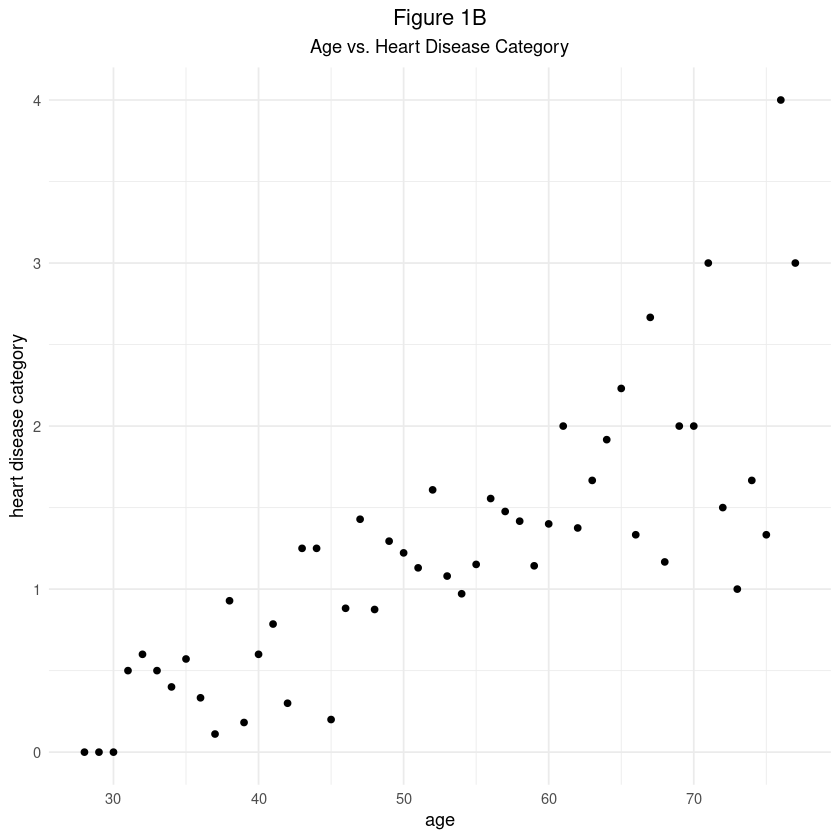

In [12]:
# Scatter plot showing average heart disease category per age.
average_category_per_age = aggregate(num ~ age, heart_disease_data, mean)
ggplot(average_category_per_age, aes(x=age, y=num)) + ggtitle(label='Figure 1B', subtitle='Age vs. Heart Disease Category') + ylab('heart disease category') + geom_point() + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [13]:
# Compare the age variance in each target category and
# whether or not the sample population is normally distributed.
compare_category_variance(heart_disease_data, 'age')

Category 0 variance: 83.8 Shapiro-Wilk p-value: 0.0980
Category 1 variance: 94.1 Shapiro-Wilk p-value: 0.0045
Category 2 variance: 72.3 Shapiro-Wilk p-value: 0.4151
Category 3 variance: 66.2 Shapiro-Wilk p-value: 0.9423
Category 4 variance: 63.3 Shapiro-Wilk p-value: 0.6177


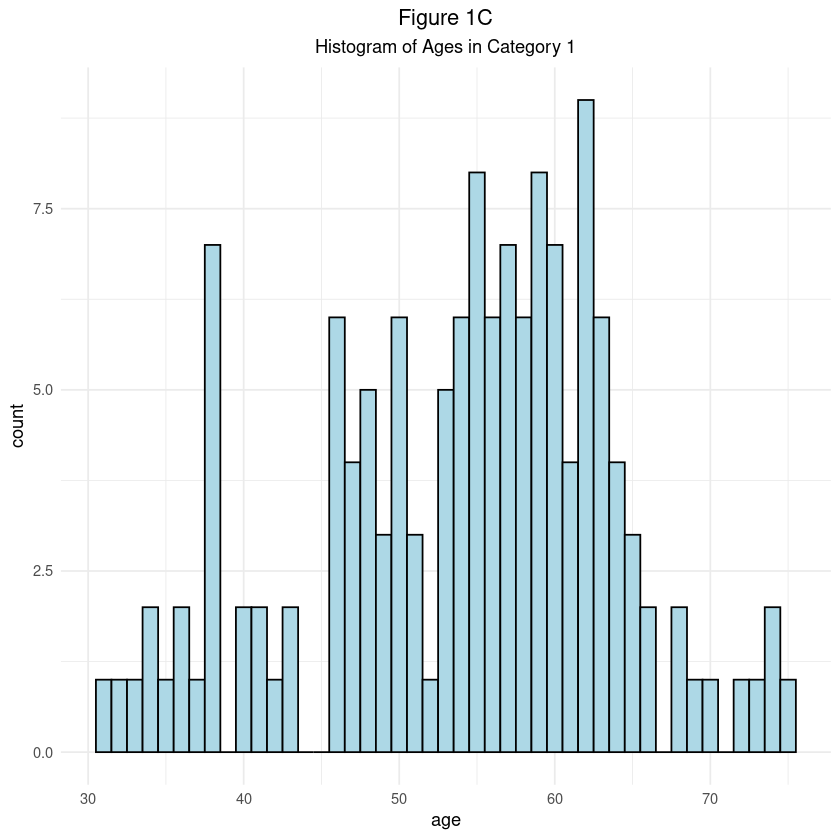

In [14]:
# Histogram of ages in category 1
# The null hypothesis for the Shapiro-Wilk test was rejected for category 1,
# so we need to investigate it further to determine if we can apply ANOVA to 
# this attribute. The histogram below appears to show that the sample 
# population is roughly normal with a slight left-tailed skew. The skew is
# quite slight, and the sample size for category 1 is large enough that we 
# can treat it as normal.
category1_data <- heart_disease_data[heart_disease_data$num == 1,]
ggplot(category1_data, aes(x=age)) + ggtitle(label='Figure 1C', subtitle='Histogram of Ages in Category 1') + geom_histogram(binwidth=1, color='black', fill='lightblue') + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [15]:
# Fligner-Killeen test of ages in the target categories.
# We failed to reject the null hypothesis for this test.
# Therefore, we treat the sample population variances as 
# approximately equal.
fligner_killeen(heart_disease_data, 'age')


	Fligner-Killeen test of homogeneity of variances

data:  x
Fligner-Killeen:med chi-squared = 5.1273, df = 4, p-value = 0.2745


In [18]:
# Test for outliers in ages in the target categories.
# Although there are some potential outliers according to this test,
# we can see from the histograms and the listed outlier values that
# they are not extreme and that there is a relatively small number
# of them in comparison to the sample sizes. Therefore, this does
# not exclude the application of ANOVA based on the presence of
# outliers. However, we will perform the ANOVA with and without the
# outliers included in the dataset to test for significance.
category0_outliers <- outliers(heart_disease_data[heart_disease_data$num == 0,]$age)
cat('Category 0 outliers:\n')
print(category0_outliers)

category1_outliers <- outliers(heart_disease_data[heart_disease_data$num == 1,]$age)
cat('\nCategory 1 outliers:\n')
print(category1_outliers)

category2_outliers <- outliers(heart_disease_data[heart_disease_data$num == 2,]$age)
cat('\nCategory 2 outliers:\n')
print(category2_outliers)

category3_outliers <- outliers(heart_disease_data[heart_disease_data$num == 3,]$age)
cat('\nCategory 3 outliers:\n')
print(category3_outliers)

category4_outliers <- outliers(heart_disease_data[heart_disease_data$num == 4,]$age)
cat('\nCategory 4 outliers:\n')
print(category4_outliers)

Category 0 outliers:
 [1] 28 29 29 30 31 68 68 69 72 74 75

Category 1 outliers:
[1] 31 32 33 73 74 74 75

Category 2 outliers:
[1] 32 70 72 74

Category 3 outliers:
[1] 35 41 75 77

Category 4 outliers:
[1] 41 76


In [19]:
# Test if the sample populations for age by target category are balanced.
# We can see that they are not balanced. Therefore, we can not perform
# ANOVA on the age attribute. We will thus use Kendall's rank coefficient 
# to test the correlation between age and heart disease categories.
age_num <- data.frame(age=factor(heart_disease_data$age), num=factor(heart_disease_data$num))
!is.list(replications(age ~ num, data=age_num))

[1] FALSE

In [20]:
# Test the strength of the correlation between age and heart disease
# category using Kendall's rank coefficient.
# Based on the p-value of this test, we reject the null hypothesis
# and conclude that age and heart disease category are statistically
# correlated. Therefore, we will include this attribute as a feature
# in our model.
Kendall(heart_disease_data$age, heart_disease_data$num)

tau = 0.255, 2-sided pvalue =< 2.22e-16

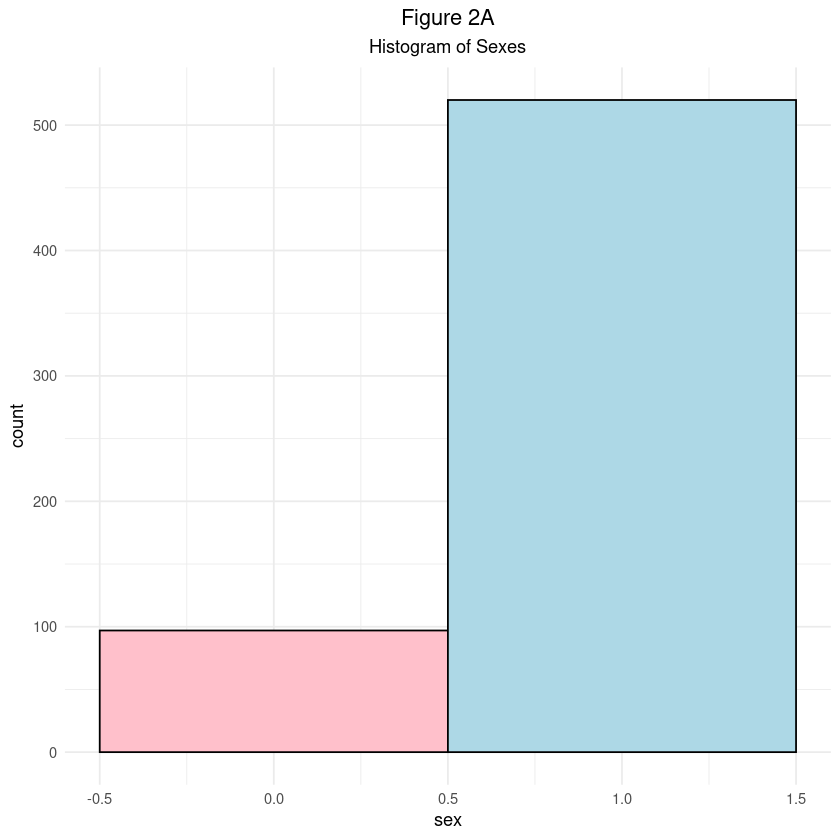

In [21]:
# Histogram of attribute sex.
ggplot(heart_disease_data, aes(x=sex)) + ggtitle(label='Figure 2A', subtitle='Histogram of Sexes') + geom_histogram(binwidth=1, color='black', fill=c('pink', 'lightblue')) + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

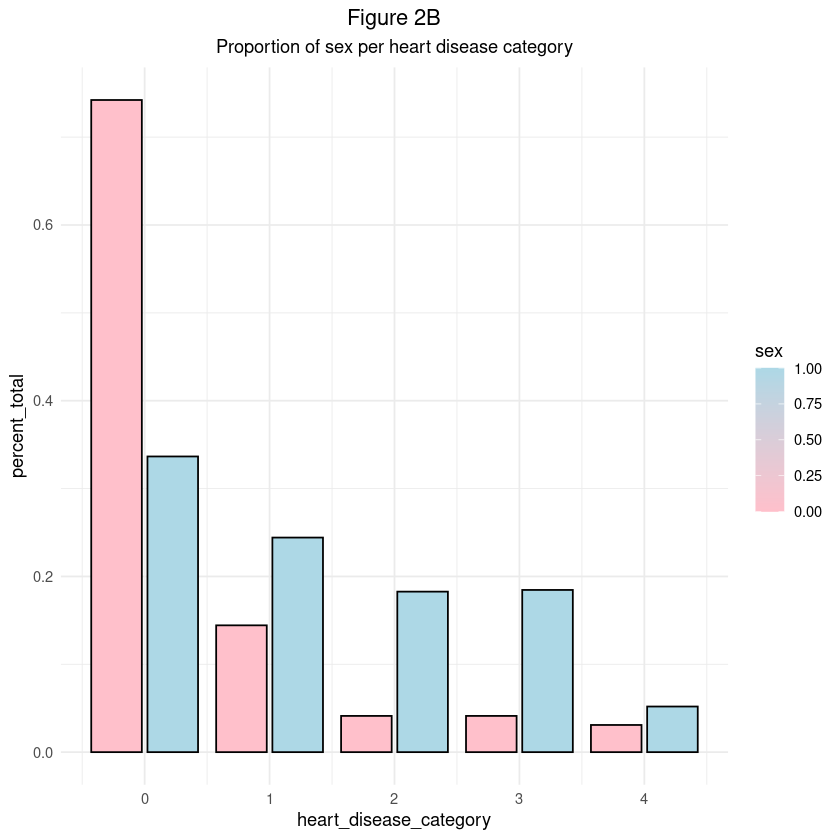

In [22]:
# Bar graph of sex grouped by heart disease category.
#
# We can see from this graph that there is a much higher proportion
# of females in category 0 and a much higher proportion of males in
# categories 2 and 3, with a slightly higher proportion of males in
# categories 1 and 4. This suggests that there is an association 
# between being sex and heart disease category.
sex_totals <- c(sum(heart_disease_data$sex == 0), 
                sum(heart_disease_data$sex == 1))

heart_disease_categories <- c(0, 0, 1, 1, 2, 2, 3, 3, 4, 4)
sexes <- c(0, 1, 0, 1, 0, 1, 0, 1, 0, 1)
percent_totals <- c()
for(index in 1:length(sexes)) {
    sex <- sexes[index]
    heart_disease_category <- heart_disease_categories[index]
    samples_per_category <- heart_disease_data[heart_disease_data$num == heart_disease_category,]$sex == sex
    sample_count <- sum(samples_per_category)
    sex_total <- sex_totals[sex+1]
    percent_totals <- append(percent_totals, c(sample_count / sex_total))
}
categories_by_sex <- data.frame('heart_disease_category'=heart_disease_categories,
                                'sex'=sexes,
                                'percent_total'=percent_totals)

ggplot(categories_by_sex, aes(fill=sex, y=percent_total, x=heart_disease_category)) + ggtitle(label='Figure 2B', subtitle='Proportion of sex per heart disease category') + geom_bar(position=position_dodge2(), stat='identity', color='black') + theme_minimal() + scale_fill_gradient(low='pink', high='lightblue') + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [38]:
# Chi-square test of sex vs. heart disease category.
#
# The p-value for the Chi-square test is below the significance
# level 0.05, so we reject the null hypothesis and conclude that 
# sex and heart disease category are dependant variables. However,
# a warning arose arose from the Chi-square test function, so we
# will use mutual information to verify the association.
males = c()
females = c()
for(num in 0:4) {
    female_count <- sum(heart_disease_data[heart_disease_data$num == num,]$sex == 0)
    male_count <- sum(heart_disease_data[heart_disease_data$num == num,]$sex == 1)
    females <- append(females, c(female_count))
    males <- append(males, c(male_count))
}
sex_categories_contingency <- data.frame('females'=females, 'males'=males)
row.names(sex_categories_contingency) <- 0:4
sex_categories_contingency
chisq.test(sex_categories_contingency)

,females,males
,<int>,<int>
0,72,175
1,14,127
2,4,95
3,4,96
4,3,27


Warning message in chisq.test(sex_categories_contingency):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  sex_categories_contingency
X-squared = 58.492, df = 4, p-value = 6.017e-12


In [24]:
# Mutual information between sex and heart disease category.
#
# The mutual information between these variables is very close
# to 0, which is envidence against the hypothesis that sex and
# heart disease category are highly correlated. Furthermore, even 
# if there is an association between sex and heart disease category,
# it seems possible that there is no a causal relationship.
# For example, it could be that men are more likely to make smoke
# than women, which leads to a higher prevalence of heart disease
# among men. This would not, however, mean that being male inherently
# places one at a higher risk for heart disease. Therefore, this 
# attribute will be discluded from the model.
mutinformation(heart_disease_data$sex, heart_disease_data$num)

[1] 0.04931598

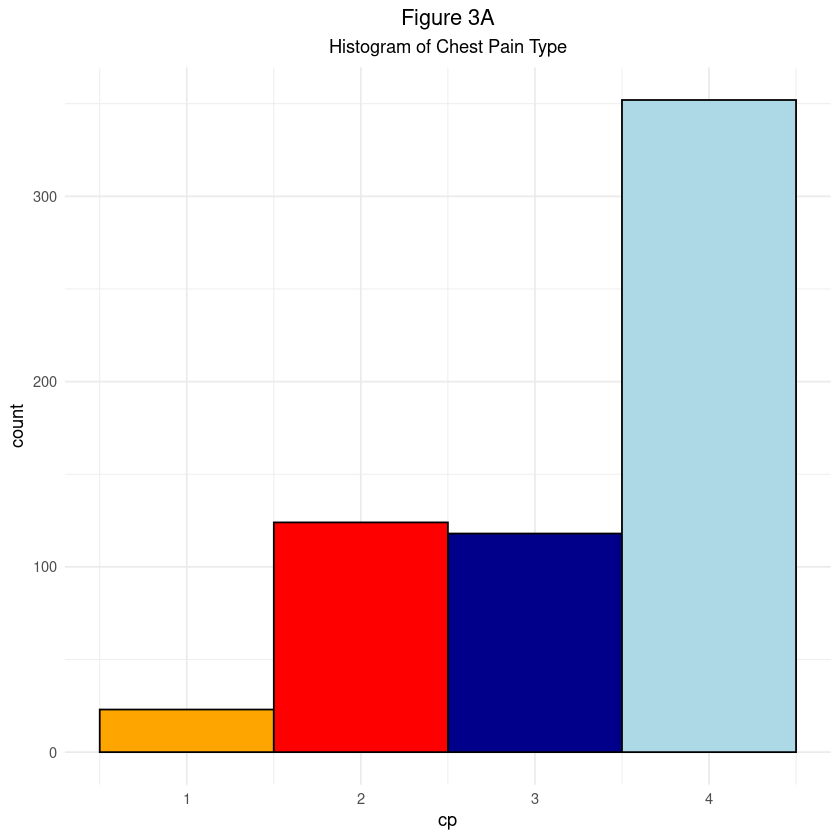

In [25]:
# Histogram of attribute cp (chest pain type).
ggplot(heart_disease_data, aes(x=cp)) + ggtitle(label='Figure 3A', subtitle='Histogram of Chest Pain Type') + geom_histogram(binwidth=1, color='black', fill=c('orange', 'red', 'darkblue', 'lightblue')) + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

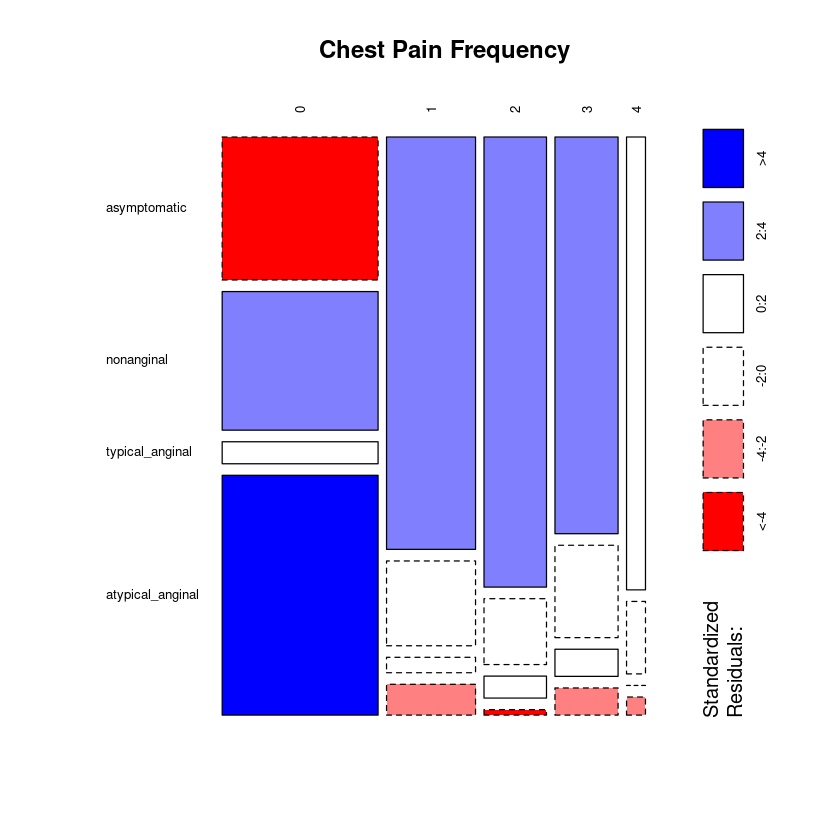

In [28]:
# Mosaic plot of chest pain type vs. heart disease category.
#
# The plot does not seem to indicate a clear association between 
# chest pain type and heart disease category.
asymptomatic = c()
nonanginal = c()
typical_anginal = c()
atypical_anginal = c()
for(num in 0:4) {
    asymptomatic_count <- sum(heart_disease_data[heart_disease_data$num == num,]$cp == 4)
    nonanginal_count <- sum(heart_disease_data[heart_disease_data$num == num,]$cp == 3)
    typical_anginal_count <- sum(heart_disease_data[heart_disease_data$num == num,]$cp == 1)
    atypical_anginal_count <- sum(heart_disease_data[heart_disease_data$num == num,]$cp == 2)
    asymptomatic <- append(asymptomatic, c(asymptomatic_count))
    nonanginal <- append(nonanginal, c(nonanginal_count))
    typical_anginal <- append(typical_anginal, c(typical_anginal_count))
    atypical_anginal <- append(atypical_anginal, c(atypical_anginal_count))
}
chest_pain_categories_contingency <- data.frame('asymptomatic'=asymptomatic, 
                                                'nonanginal'=nonanginal,
                                                'typical_anginal'=typical_anginal,
                                                'atypical_anginal'=atypical_anginal)

row.names(chest_pain_categories_contingency) <- 0:4
mosaicplot(chest_pain_categories_contingency, shade=TRUE, las=2, main='Chest Pain Frequency')

In [39]:
# Chi-square test of chest pain type vs. heart disease category.
# 
# The p-value for the Chi-square test is less than the significance
# level of 0.05, so we reject the null hypothesis and conclude that
# the variables are dependant on the basis of the test. However,
# the Chi-square test function issued a warning, so we will look at
# the mutual information to verify the association.
chest_pain_categories_contingency
chisq.test(chest_pain_categories_contingency)

,asymptomatic,nonanginal,typical_anginal,atypical_anginal
,<int>,<int>,<int>,<int>
0,65,63,10,109
1,107,22,4,8
2,82,12,4,1
3,73,17,5,5
4,25,4,0,1


Warning message in chisq.test(chest_pain_categories_contingency):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  chest_pain_categories_contingency
X-squared = 199.77, df = 12, p-value < 2.2e-16


In [30]:
# Mutual information between chest pain and heart disease category.
#
# The low mutual information between these variables indicates a weak
# correlation between chest pain type and heart disease category. This
# is surprising, given that anginal chest pain is a classical symptom
# of heart disease in the medical literature. This may be due to a 
# misclassification of chest pain type in the data source. Similarly,
# this may be a poor choice for a model feature due to the difficulty
# in determining if chest pain is truly anginal without confirming the
# presence of heart disease (i.e. anginal pain implies heart disease).
# Of course, detecting the presence of heart disease is the very 
# purpose of the model, so this is not a suitable feature. However,
# we will now investigate whether a binary chest pain class - pain
# of any kind vs. no pain - may be suitable to include.
mutinformation(heart_disease_data$cp, heart_disease_data$num)

[1] 0.1757155

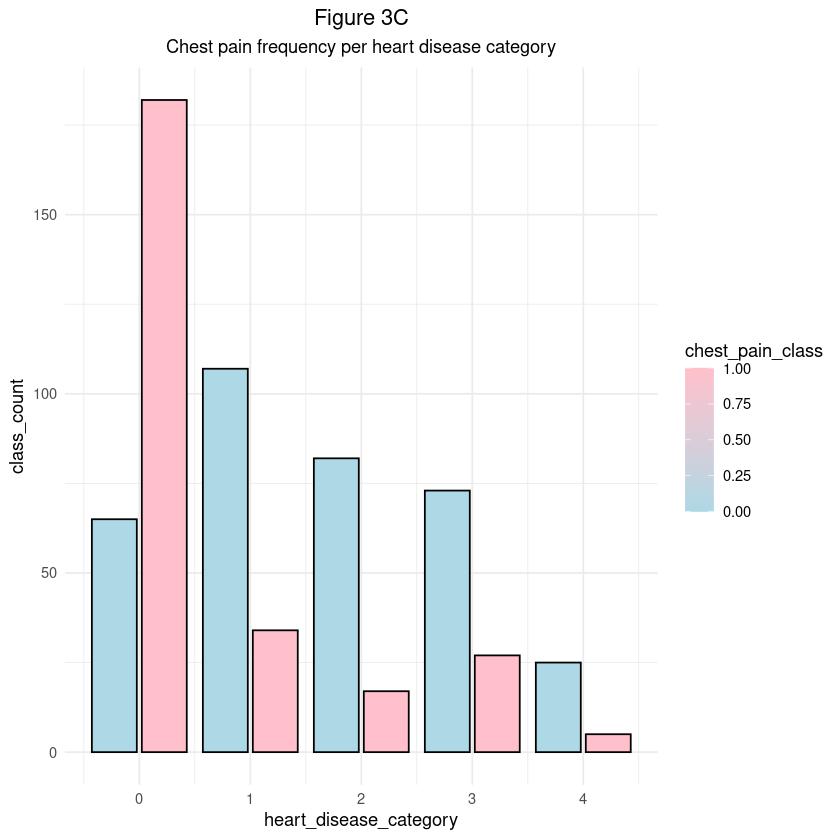

In [35]:
# Bar graph of binary chest pain class grouped by heart disease category.
heart_disease_categories <- c(0, 0, 1, 1, 2, 2, 3, 3, 4, 4)
pain_classes <- c(0, 1, 0, 1, 0, 1, 0, 1, 0, 1)
class_count <- c()
for(index in 1:length(pain_classes)) {
    pain_class <- pain_classes[index]
    heart_disease_category <- heart_disease_categories[index]
    category_data <- heart_disease_data[heart_disease_data$num == heart_disease_category,]
    if(pain_class == 0) {
        samples_per_category <- category_data$cp == 4
    }
    else {
        samples_per_category <- category_data$cp != 4
    }
    sample_count <- sum(samples_per_category)
    class_count <- append(class_count, c(sample_count))
}
categories_by_pain_class <- data.frame('heart_disease_category'=heart_disease_categories,
                                       'chest_pain_class'=pain_classes,
                                       'class_count'=class_count)

ggplot(categories_by_pain_class, aes(fill=chest_pain_class, y=class_count, x=heart_disease_category)) + ggtitle(label='Figure 3C', subtitle='Chest pain frequency per heart disease category') + geom_bar(position=position_dodge2(), stat='identity', color='black') + theme_minimal() + scale_fill_gradient(low='lightblue', high='pink') + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [37]:
# Chi-square test of binary chest pain class vs. heart disease category.
#
# The p-value for the Chi-square test is less than the significance
# level of 0.05, so we reject the null hypothesis and conclude that
# the variables are dependant on the basis of the test. However,
# this result is suspect given that the above bar graph indicates
# the association is negative - the opposite of what the medical 
# literature indicates. Because of this, chest pain will not be
# included as a feature in the model.
chest_pain_negative <- c()
chest_pain_positive <- c()
for(num in 0:4) {
    pain_negative_count <- sum(heart_disease_data[heart_disease_data$num == num,]$cp == 4)
    pain_positive_count <- sum(heart_disease_data[heart_disease_data$num == num,]$cp != 4)
    chest_pain_negative <- append(chest_pain_negative, c(pain_negative_count))
    chest_pain_positive <- append(chest_pain_positive, c(pain_positive_count))
}
pain_class_categories_contingency <- data.frame('chest_pain_negative'=chest_pain_negative, 
                                                'chest_pain_positive'=chest_pain_positive)

row.names(pain_class_categories_contingency) <- 0:4
pain_class_categories_contingency
chisq.test(chest_pain_categories_contingency)

,chest_pain_negative,chest_pain_positive
,<int>,<int>
0,65,182
1,107,34
2,82,17
3,73,27
4,25,5


Warning message in chisq.test(chest_pain_categories_contingency):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  chest_pain_categories_contingency
X-squared = 199.77, df = 12, p-value < 2.2e-16
